In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import zipfile
from pathlib import Path
pd.options.mode.chained_assignment = None # no warning message and no exception is raised

In [2]:
class COVID_analysis(object):
    
    # See http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip
    # Dictionnary giving codes for the Municipio and the Entidad (State).
    places_dic = {'MEXICO': (None, None), # Whole country
                  'MÉXICO': (None, None), # Whole country
                    'AGUASCALIENTES': (None, 1),
                    'BAJA CALIFORNIA': (None, 2),
                    'BAJA CALIFORNIA SUR': (None,3),
                    'CAMPECHE': (None,4),
                    'COAHUILA DE ZARAGOZA': (None,5),
                    'COAHUILA': (None,5),
                    'COLIMA': (None,6),
                    'CHIAPAS': (None,7),
                    'CHIHUAHUA': (None,8),
                    'CIUDAD DE MÉXICO': (None,9),
                    'CDMX': (None, 9),
                    'DURANGO': (None,10),
                    'GUANAJUATO': (None,11),
                    'GUERRERO': (None,12),
                    'HIDALGO': (None,13),
                    'JALISCO': (None,14),
                    'ESTADO DE MÉXICO': (None,15),
                    'Total de la entidad México':(None,15),
                    'MICHOACÁN DE OCAMPO': (None,16),
                    'MICHOACÁN': (None,16),
                    'MORELOS': (None,17),
                    'NAYARIT': (None,18),
                    'NUEVO LEÓN': (None,19),
                    'OAXACA': (None,20),
                    'ESTADO DE PUEBLA': (None,21),
                    'PUEBLA': (None,21),
                    'QUERÉTARO': (None,22),
                    'QUINTANA ROO': (None,23),
                    'SAN LUIS POTOSÍ': (None,24),
                    'SINALOA': (None,25),
                    'SONORA': (None,26),
                    'TABASCO': (None,27),
                    'TAMAULIPAS': (None,28),
                    'TLAXCALA': (None,29),
                    'VERACRUZ DE IGNACIO DE LA LLAV': (None,30),
                    'VERACRUZ': (None,30),
                    'YUCATÁN': (None,31),
                    'ZACATECAS': (None,32),
                    'ESTADOS UNIDOS MEXICANOS': (None,36),
                    'NO APLICA': (None,97),
                    'SE IGNORA': (None,98),
                    'NO ESPECIFICADO': (None,99)}

    # Data from https://www.gob.mx/salud/documentos/datos-abiertos-152127

    # WARNING: this data file is only accesible from Mexico 
    url = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip'
    url_dic = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip'
    url_pob = 'https://www.inegi.org.mx/contenidos/programas/ccpv/2020/datosabiertos/iter/iter_00_cpv2020_csv.zip'
    
    def __init__(self, date, data_dir = '/tmp/', dic_dir = './', verbose=True):
        """
        Class to manage the data from the mexican "datosabiertos" webserver.
        The class read the datafile and filter it to keep only the confirmed cases. 
        It allows to select a Municipio to plot the corresponding history of the casos/muertos.
        Multiple plots can be managed.
        Parameters
        ----------
        date : string e.g. '210209' corresponding to the file downloaded from datos_abiertos
               Date of the data to consider for the analysis.
               'last' will scann the data_dir for the latest available date.
               'current' will download the current data from datos_abiertos and use it
        data_dir : String, optional
            Directory where to find the data file. The default is /tmp/ .
        dic_dir : String, optional
            Directory where to find the dictionnary file. The default is ./ .
        verbose : Boolean
            Verbosity. The default is True

        Returns
        -------
        None.
        
        Example
        -------
        C = COVID_analysis('current', data_dir='/tmp/')
        C.plot_muliple(places=('MÉXICO', 'BAJA CALIFORNIA', 'CDMX', 
                               'Ensenada', 'Tijuana', 'Mexicali',
                               'Coyoacan', 'Tlalpan', 'Puebla',
                               'Hermosillo', 'Guadalajara', 'Monterrey',
                               'Morelia', 'Culiacán', 'Caborca')) 
        """
        self.d = None
        self.d_c = None
        self.verbose = verbose
        
        self.data_dir = data_dir
        self.dic_dir = dic_dir
        self._read_dic()
        self._read_pob()
        self.date = date
        if self.date is not None:
            self._read_data()
        
        
    def _dl_diccionarios(self):
        """
        Download the dictionnary conataing the codes for the differents towns (municipios) in Mexico.
        Also unpack the file after download.
        This action can only be performed from computer with Mexican IP.
        This method is called by self._read_dic()
        """
        if self.verbose:
            print('Downloading Dictionnary from datosabiertos server.')
        zip_file = Path(self.dic_dir) / Path('diccionario_datos_covid19.zip')
        urllib.request.urlretrieve(COVID_analysis.url_dic, zip_file)
        dic_dir2 = Path(self.dic_dir) / Path('diccionario_datos_covid19')
        dic_dir2.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(zip_file,"r") as zip_ref:
            zip_ref.extractall(dic_dir2)
        if zip_file.exists():
            zip_file.unlink()
        
    def _dl_data(self):
        """
        Download the public data from Mexican government
        This method is called by self._read_data()
        """
        if self.verbose:
            print('Downloading from datosabiertos server. May take a few minutes.')
        dest_file = Path(self.data_dir) / Path('datos_abiertos_covid19.zip')
        urllib.request.urlretrieve(COVID_analysis.url, dest_file)
        with zipfile.ZipFile(dest_file,"r") as zip_ref:
            zip_ref.extractall(self.data_dir)
        if dest_file.exists():
            dest_file.unlink()
        if self.verbose:
            print('Usable dates found in {}: {}'.format(self.data_dir, 
                            sorted([f.name[0:6] for f in Path(self.data_dir).glob('*COVID19MEXICO.csv')], reverse=True)))
            
    def _dl_poblacion(self):
        """
        Download the file from INEGI with the poblacion of the municipios
        """
        if self.verbose:
            print('Downloading from INEGI server. May take a few minutes.')
        pob_file = Path(self.data_dir) / Path('iter_00_cpv2020_csv.zip')
        urllib.request.urlretrieve(COVID_analysis.url_pob, pob_file)
        with zipfile.ZipFile(pob_file,"r") as zip_ref:
            zip_ref.extractall(self.data_dir / Path('iter_00_cpv2020_csv'))
        if pob_file.exists():
            pob_file.unlink()               
            
    def _read_dic(self):
        """
        Read the dictionary and save result in self.municipios. 
        If the file is not read, try to download it.
        This method is called from instantiation.
        """
        dic_file = Path(self.dic_dir) / Path('diccionario_datos_covid19') / Path('201128 Catalogos.xlsx')
        try:
            if self.verbose:
                print('Reading Dictionnary at {} for Place codes.'.format(dic_file))
            self.municipios = pd.read_excel(dic_file, sheet_name='Catálogo MUNICIPIOS')
        except:
            # Download the file
            self._dl_diccionarios()
            try:
                if self.verbose:
                    print('Reading Dictionnary at {} for Place codes.'.format(dic_file))
                self.municipios = pd.read_excel(dic_file, sheet_name='Catálogo MUNICIPIOS')
            except:
                if self.verbose:
                    print('Dictionnary not read after trying to download it.')
                self.municipios = None
    
    def _read_data(self):
        """
        Read the datafile corresponding to the date given at instantiation.
        If not present on disk, download the file.
        This method is called from instantiation if date is not None.
        """
        if self.date == 'last':
            try:
              self.date = sorted([f.name[0:6] for f in Path(self.data_dir).glob('*COVID19MEXICO.csv')], reverse=True)[0]
            except:
              self._dl_data()
              self.date = sorted([f.name[0:6] for f in Path(self.data_dir).glob('*COVID19MEXICO.csv')], reverse=True)[0]   
        if self.date == 'current':
            self._dl_data()
            self.date = sorted([f.name[0:6] for f in Path(self.data_dir).glob('*COVID19MEXICO.csv')], reverse=True)[0]
        data_file = Path(self.data_dir) / Path(self.date + 'COVID19MEXICO.csv')
        try:
            if self.verbose:
                print('Reading {}. Huge file of {:.0f} Mo ... takes a while.'.format(data_file, data_file.stat().st_size/1024/1024))
            self.d = pd.read_csv(data_file, encoding = 'latin')
            if self.verbose:
                print('Data read. {} records'.format(len(self.d)))
        except:
            if self.verbose:
                print("""File {} not found. Will try to download from the datosabiertos server. 
May take few minutes.""".format(data_file))
            self._dl_data()
            try:
                if self.verbose:
                    print('Reading {}. Huge file of {:.0f} Mo ... takes a while.'.format(data_file, data_file.stat().st_size/1024/1024))
                self.d = pd.read_csv(data_file, encoding = 'latin')
                if self.verbose:
                    print('Data read. {} records'.format(len(self.d)))
            except:
                if self.verbose:
                    print('File {} not read after trying to download it.'.format(data_file))
                self.d = None
                
    def _read_pob(self):
        pob_file = Path(self.data_dir) / Path('iter_00_cpv2020_csv') / Path('conjunto_de_datos') / Path('conjunto_de_datos_iter_00_cpv2020.csv')
        try:
            if self.verbose:
                print('Reading Population at {}.'.format(pob_file))
            self.poblacion = pd.read_csv(pob_file)
        except:
            # Download the file
            self._dl_poblacion()
            try:
                if self.verbose:
                    print('Reading Population at {}.'.format(pob_file))
                self.poblacion = pd.read_csv(pob_file)
            except:
                if self.verbose:
                    print('Population not read after trying to download it.')
                self.poblacion = None
    
    def get_pob(self, place=None):
        
        if place is None:
            place = self.place
        if place in ('México', 'MÉXICO'):
            pob = np.sum(self.poblacion[self.poblacion['NOM_MUN'] == 'Total nacional']['POBTOT'])
        elif place == 'CDMX':
            pob = np.sum(self.poblacion[self.poblacion['NOM_MUN'] == 'Total de la entidad Ciudad de México']['POBTOT'])            
        else:
            pob = np.max(self.poblacion[self.poblacion['NOM_MUN'] == place]['POBTOT'])
            if pob is np.nan:
                to_search = 'Total de la entidad {}'.format(place.title().replace(' De ', ' de ').replace(' La ', ' la '))
                pob = np.sum(self.poblacion[self.poblacion['NOM_MUN'] == to_search]['POBTOT'])
                if pob is np.nan:
                    to_search = 'Total de la entidad {}'.format(place.lower())
                    pob = np.sum(self.poblacion[self.poblacion['NOM_MUN'] == to_search]['POBTOT'])                    
        return pob
    
    def grep_place(self, pattern):
        """
        Search the database of Municipios for a given string
        """
        
        matches = [pattern.upper() in municipio for municipio in C.municipios['MUNICIPIO'].values]
        return self.municipios['MUNICIPIO'].values[matches]
    
    def add_place(self, name):
        """
        Add the index of the municipio defined by "name" to the inner dictionnary. 
        User need to gave the name with accents.
        """
        if self.municipios is None:
            if self.verbose:
                print('No dictionnary to deal with.')
            return 
            
        mask = self.municipios['MUNICIPIO'] == name.upper()
        if mask.sum() == 0:
            print('No matching Municipio')
        elif mask.sum() == 1:
            if self.verbose:
                i_mun = self.municipios[mask]['CLAVE_MUNICIPIO'].values[0]
                i_ent = self.municipios[mask]['CLAVE_ENTIDAD'].values[0]
                print('Municipio {} found: {} {} {}'.format(name.upper(), i_mun, i_ent, self.get_pob(name)))
                COVID_analysis.places_dic[name] = (i_mun, i_ent)
    
    def define_data(self, place='Ensenada'):
        """
        Define the data that will be plotted, using the name of the place: May be "Mexico", a State or a Municipio.
        """
        if self.d is None:
            if self.verbose:
                print('No data to deal with.')
            return 
        self.place=place
        if place not in COVID_analysis.places_dic:
            self.add_place(place)
        if place in COVID_analysis.places_dic:
            ME = COVID_analysis.places_dic[place]
            self._select_data(Municipio = ME[0], Entidad = ME[1])
        else:
            if self.verbose:
                print('Place {} not found'.format(place))
    
        
    def _select_data(self, Municipio=1, Entidad=2):
        """
        Select the data used, once the incides of the MUNICIPIO and ENTIDAD are determined.
        This method is called by self.define_data(place).
        """
        if self.d is None:
            if self.verbose:
                print('No data to deal with.')
            return 
        
        if Municipio is None:
            m1 = True
        else:
            m1 = self.d['MUNICIPIO_RES'] == Municipio # 1: Ensenada, 2:Mexicali, 3:Tecate, 4: Tijuana, 5:Rosarito, 3: Coyoacan, 114:Puebla, 
        if Entidad is None:
            m2 = True
        else:
            m2 = self.d['ENTIDAD_RES'] == Entidad # 2: BC, 9: CDMX, 21: Puebla
        # We want only the confirmed cases: code 1, 2 or 3 on this:    
        m3 = self.d['CLASIFICACION_FINAL'] == 1
        m4 = self.d['CLASIFICACION_FINAL'] == 2
        m5 = self.d['CLASIFICACION_FINAL'] == 3
        
        m_select = m1 & m2 & (m3 | m4 | m5)
        d = self.d[m_select]
    
        m = d['FECHA_DEF'] == '9999-99-99' # SI no defuncion: puro caso
    
        d_c = d # casos
        d_m = d[~m] # muertos
    
        d_c['FECHA'] = pd.to_datetime(d_c['FECHA_SINTOMAS'], format="%Y-%m-%d")                      
        d_m['FECHA'] = pd.to_datetime(d_m['FECHA_DEF'], format="%Y-%m-%d")                      
    
        self.d_c = d_c.groupby('FECHA').count()['ID_REGISTRO']
        self.d_m = d_m.groupby('FECHA').count()['ID_REGISTRO']


    def plot_data(self, roll=7, cut=5, ax=None, ylim1=None, ylim2=None, c1=0, c2=1, norm=True):
        """
        Plot the cases and deaths for the location defined when calling self.define_data(place).
        roll is the rolling performed on the data time.
        cut defines the number of last days NOT to be used.
        ax is an axis object.
        c1 ans c2 are color codes.
        """
        if self.d_c is None:
            if self.verbose:
                print('No data to deal with.')
            return 
        if ax is None:
            f, ax = plt.subplots()
        tot_casos = self.d_c.sum()
        tot_muertos = self.d_m.sum()
        pob = self.get_pob()
        if pob is None:
            casos_str = 'Casos: {}'.format(tot_casos)
            muertos_str = 'Muertos: {} [{:.1f}%]]'.format(tot_muertos, tot_muertos/tot_casos*100)
        else:
            casos_str = 'Casos: {} ({:.0f})'.format(tot_casos, tot_casos/pob*1e5)
            muertos_str = 'Muertos: {} ({:.0f} [{:.1f}%])'.format(tot_muertos, tot_muertos/pob*1e5, tot_muertos/tot_casos*100)
        if norm:
            fact = pob/1e5
        else:
            fact = 1.
        (self.d_c[:-cut]/fact).rolling(roll).mean().plot(ax=ax, drawstyle="steps", c='C{}'.format(c1), 
                                                          label=casos_str)
        ax2 = ax.twinx()
        (self.d_m[:-cut]/fact).rolling(roll).mean().plot(ax=ax2, drawstyle="steps", c='C{}'.format(c2), 
                                                          label=muertos_str)
        ax.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp.today())
        ax2.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp.today())
        ll = ax.lines + ax2.lines
        lb = [l.get_label() for l in ll]
        ax.legend(ll, lb, loc='upper left')
        ax.set_ylabel('Casos/100,000')
        ax2.set_ylabel('Muertos/100,000')
        ax.set_title(self.place)
        if ylim1 is not None:
            ax.set_ylim(ylim1)
        else:
            ax.set_ylim(bottom=0)
        if ylim2 is not None:
            ax2.set_ylim(ylim2)
        else:
            ax2.set_ylim(bottom=0)
        ax.grid(True,which="major", linestyle='--')
        
        
    def plot_multiple(self, places=('MÉXICO', 'BAJA CALIFORNIA', 'CDMX'), 
                     axes=None,
                     fig_file = None,
                     get_axes=False, roll=7, cut=5, norm=True):
        """
        Plot multiple time evolutions of cases/deaths for different places. 
        If a place is not in the default inner dictionnary, it is looked for into the dictionnary read from the disk.
        """
        
        if self.d is None:
            if self.verbose:
                print('No data to deal with.')
            return 
        if axes is None:
            if len(places) == 1:
                f, axes = plt.subplots(figsize=(5,5))
                axes = np.array((axes)) # to allow the use of ravel in the forthcoming loop
            elif len(places) == 2:
                f, axes = plt.subplots(1,2,figsize=(10,5))
            else:
                n_y = ((len(places) - 1) // 3) + 1
                f, axes = plt.subplots(n_y,3,figsize=(16,n_y*5))
        else:
            f = plt.gcf()
        for place, ax in zip(places, axes.ravel()):
            self.define_data(place)
            self.plot_data(ax=ax, roll=roll, cut=cut, norm=norm, ylim1=(0, 50), ylim2=(0,4.0))
        f.tight_layout()
        if fig_file is not None:
            f.savefig('{}_{}.pdf'.format(fig_file, self.date))
        if get_axes:
            return axes
        
    def print_stats_states(self):
        old_verbose = self.verbose
        self.verbose = False
        print("      STATE                      Population  cases    deaths cases/1e5 deaths/1e5  deaths/cases %")
        for entidad in COVID_analysis.places_dic:
            self.define_data(entidad)
            tot_casos = self.d_c.sum()
            tot_muertos = self.d_m.sum()
            pob = self.get_pob()
            if pob > 0:
                print('{:30s} : {:9.0f} {:8.0f} {:8.0f}     {:4.0f}       {:3.0f}        {:4.1f}'.format(entidad, pob, 
                                                                                        tot_casos, 
                                                                                        tot_muertos,
                                                                                        tot_casos/pob*1e5, 
                                                                                        tot_muertos/pob*1e5,
                                                                                        tot_muertos/tot_casos*100))
        self.verbose = old_verbose

### Instantiate the class that manage the data.

In [3]:
C = COVID_analysis('current', data_dir='.', dic_dir='.')

Reading Dictionnary at diccionario_datos_covid19/201128 Catalogos.xlsx for Place codes.
Reading Population at iter_00_cpv2020_csv/conjunto_de_datos/conjunto_de_datos_iter_00_cpv2020.csv.


/home/morisset/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Usable dates found in .: ['220101', '211214']
Reading 220101COVID19MEXICO.csv. Huge file of 1919 Mo ... takes a while.


/home/morisset/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data read. 12414103 records


### Search for places using a grep-like method

In [4]:
C.grep_place('uli')

array(['JULIMES', 'SAN JULIÁN', 'ASUNCIÓN TLACOLULITA', 'CULIACÁN'],
      dtype=object)

### Plot different places. 

Municipio ENSENADA found: 1 2 443807
Municipio TIJUANA found: 4 2 1922523
Municipio MEXICALI found: 2 2 1049792
Municipio COYOACÁN found: 3 9 614447
Municipio TLALPAN found: 12 9 699928
Municipio PUEBLA found: 114 21 1692181
Municipio HERMOSILLO found: 30 26 936263
Municipio GUADALAJARA found: 39 14 1385629
Municipio MONTERREY found: 39 19 1142994
Municipio MORELIA found: 53 16 849053
Municipio CULIACÁN found: 6 25 1003530
Municipio MÉRIDA found: 50 31 995129


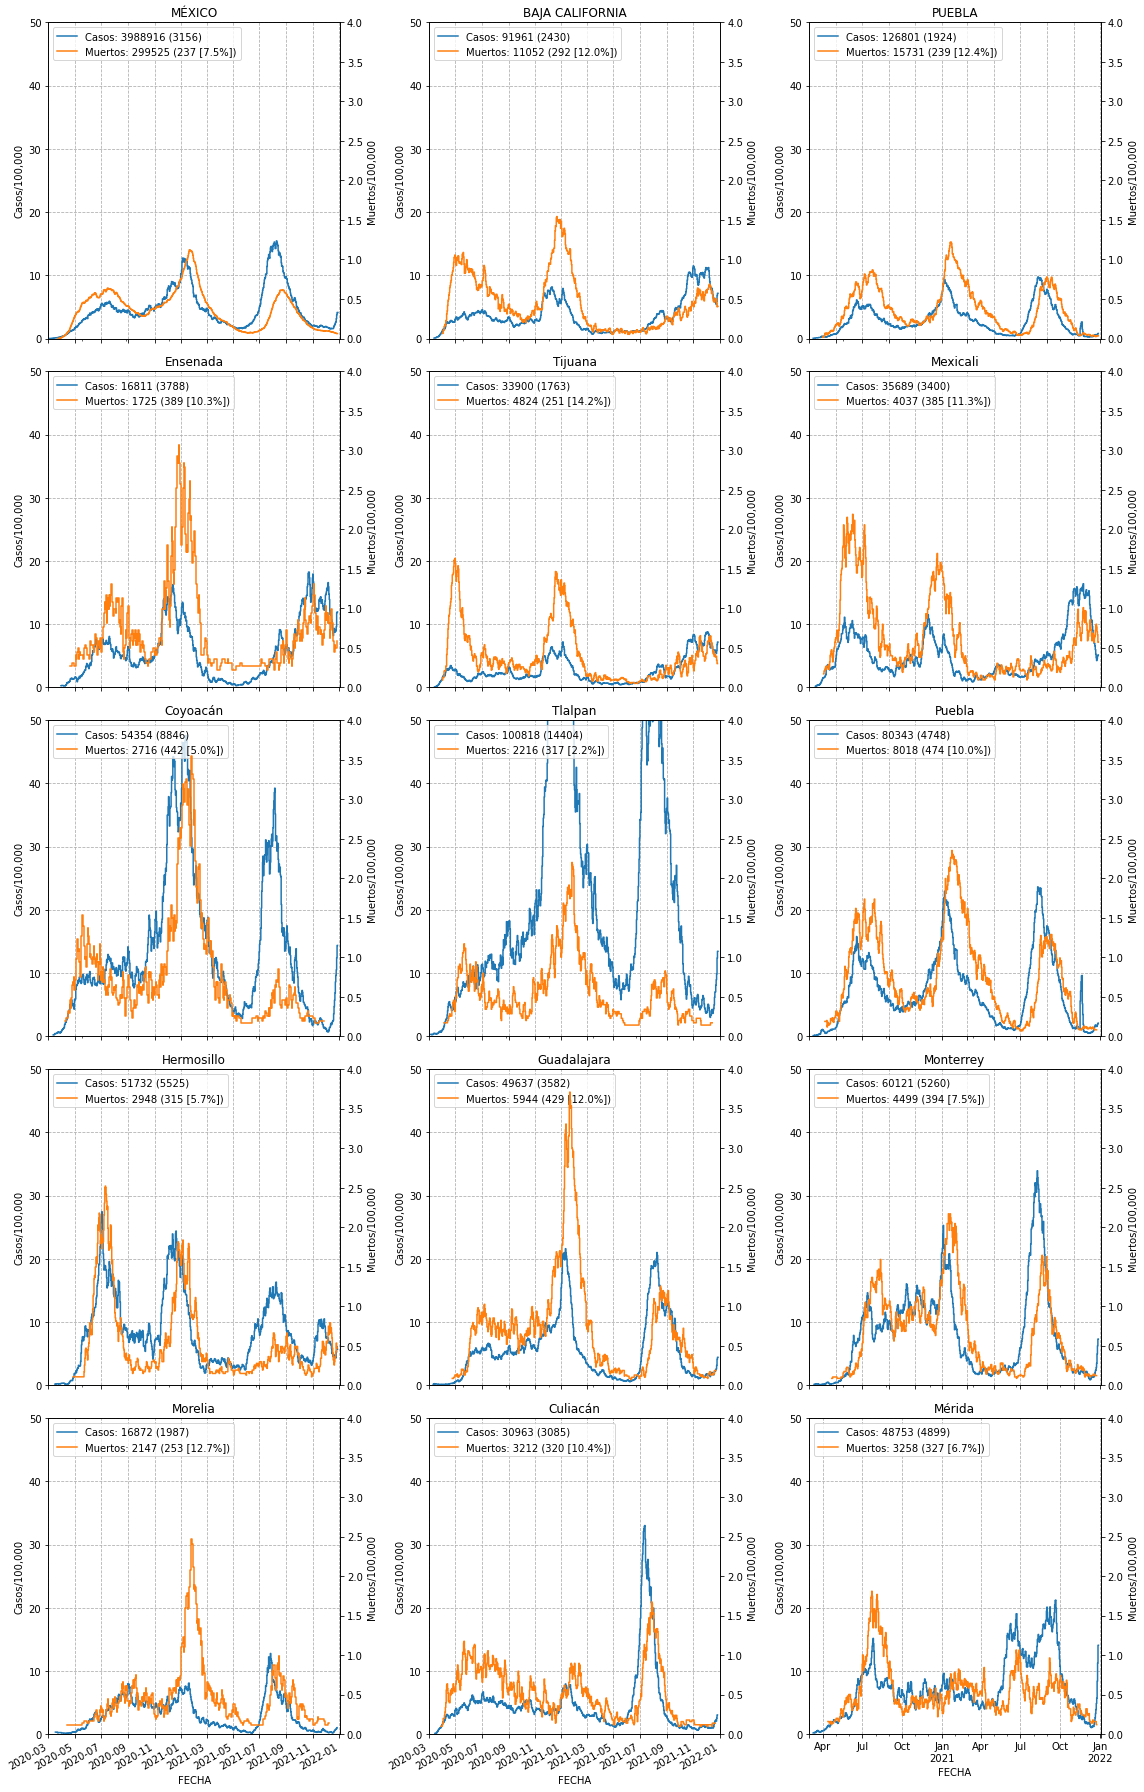

In [5]:
C.plot_multiple(places=('MÉXICO', 'BAJA CALIFORNIA', 'PUEBLA', 
                       'Ensenada', 'Tijuana', 'Mexicali',
                       'Coyoacán', 'Tlalpan', 'Puebla',
                       'Hermosillo', 'Guadalajara', 'Monterrey',
                       'Morelia', 'Culiacán', 'Mérida'),
                fig_file = 'COVID', cut=3, roll=5)
# Plot the data for the specifies locations
# Casos: Total Number of cases (Total / 100,000 habs)
# Muertos: Total number of deaths (Total / 100,000 habs [deaths/cases %])

In [6]:
C.print_stats_states()

      STATE                      Population  cases    deaths cases/1e5 deaths/1e5  deaths/cases %
MÉXICO                         : 126411503  3988916   299525     3156       237         7.5
AGUASCALIENTES                 :   1432325    39406     3034     2751       212         7.7
BAJA CALIFORNIA                :   3783852    91961    11052     2430       292        12.0
BAJA CALIFORNIA SUR            :    806190    62482     2426     7750       301         3.9
CAMPECHE                       :    935739    24428     2106     2611       225         8.6
COAHUILA DE ZARAGOZA           :   3158312   102367     7810     3241       247         7.6
COLIMA                         :    735166    33460     2040     4551       277         6.1
CHIAPAS                        :   5591856    23660     2297      423        41         9.7
CHIHUAHUA                      :   3773703    81054     8743     2148       232        10.8
CIUDAD DE MÉXICO               :   9210628  1005736    40332     10919    